# Competitors

28 June, 2024

@roman

Code to find neighbors of a given competitor for each property.

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import h3

from scipy.spatial import KDTree
from sklearn.cluster import MiniBatchKMeans, SpectralClustering
from INEGIpy import MarcoGeoestadistico

In [2]:
# Settings
# show 100 columns in pandas
pd.set_option('display.max_columns', 100)
geo_framework = MarcoGeoestadistico()

---
# Data

## Properties

In [3]:
# read parquet
gdf_properties = pd.read_parquet("../../data/interim/cleaned_data_s4.parquet")

# to geopandas
gdf_properties = gpd.GeoDataFrame(
    gdf_properties,
    geometry=gpd.points_from_xy(gdf_properties['longitud'], gdf_properties['latitud']),
    crs="EPSG:4326"
    )

# change crs to 6372
gdf_properties = gdf_properties.to_crs("EPSG:6372")

gdf_properties.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 852931 entries, 0 to 853032
Data columns (total 42 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   property_id                    852931 non-null  object        
 1   valor_fisico_construccion      852931 non-null  float64       
 2   id_avaluo                      852931 non-null  object        
 3   fecha_avaluo                   852931 non-null  datetime64[ns]
 4   colonia                        852931 non-null  object        
 5   id_clase_inmueble              852931 non-null  int64         
 6   id_tipo_inmueble               852931 non-null  int64         
 7   conservacion                   852931 non-null  float64       
 8   elevador                       824560 non-null  float64       
 9   niveles                        852931 non-null  int64         
 10  cve_ref_proximidad_urbana      852931 non-null  int64         
 1

## Cities

In [4]:
# read parquet
gdf_cities = gpd.read_parquet("../../data/misc/polygons_cities_analysis.parquet")

# change crs to 6372
gdf_cities = gdf_cities.to_crs("EPSG:6372")

gdf_cities.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   city_cluster  158 non-null    int64   
 1   geometry      158 non-null    geometry
 2   id_entidad_f  158 non-null    object  
 3   id_municipio  158 non-null    object  
dtypes: geometry(1), int64(1), object(2)
memory usage: 5.1+ KB


## Wrangle

In [5]:
# get area of each city
gdf_cities["area_city_km2"] = gdf_cities["geometry"].area / 1e+6
gdf_cities

,city_cluster,geometry,id_entidad_f,id_municipio,area_city_km2
0,0,"POLYGON ((2802508.846 807491.784, 2789672.652 ...",09,003,2903.853661
1,1,"POLYGON ((1629955.271 1907389.003, 1627448.198...",26,030,209.540815
2,2,"POLYGON ((3774584.424 1040369.440, 3771144.074...",31,050,421.923013
3,3,"POLYGON ((1689809.795 1228251.713, 1688632.431...",03,008,51.820147
4,4,"POLYGON ((2925744.121 1137557.697, 2925578.403...",28,003,189.037742
...,...,...,...,...,...
153,153,"POLYGON ((2465808.773 1027282.693, 2464899.188...",14,073,1.768766
154,154,"POLYGON ((3766607.192 1039525.460, 3766036.237...",31,101,5.968569
155,155,"POLYGON ((3155663.269 722381.567, 3154738.490 ...",30,045,2.088189
156,156,"POLYGON ((1955975.906 1403742.907, 1955639.042...",25,006,1.851625


In [6]:
# join data
gdf_properties = (
    gdf_properties
    .sjoin(
        gdf_cities.loc[:, ["city_cluster", "geometry", 'area_city_km2']],
        how="left",
    )
    .drop_duplicates(subset=["property_id"], keep="first")
    .drop(columns=["index_right"])
)

# see shape
gdf_properties.shape

(852931, 44)

---
# $d_{1}$: Geospatial Distance

## EDA

In [7]:
# see how many properties are in each city
table_cities_count = (
    gdf_properties
    .groupby("city_cluster", as_index=False)
    .agg(
        count_properties=("property_id", "count"),
        area_city_km2=("area_city_km2", "first")
    )
    .assign(
        density_properties=lambda x: x["count_properties"] / x["area_city_km2"]
    )
)
table_cities_count

,city_cluster,count_properties,area_city_km2,density_properties
0,0.0,118679,2903.853661,40.869484
1,1.0,15718,209.540815,75.011639
2,2.0,20048,421.923013,47.515777
3,3.0,2139,51.820147,41.277382
4,4.0,8248,189.037742,43.631499
...,...,...,...,...
153,153.0,230,1.768766,130.034190
154,154.0,343,5.968569,57.467713
155,155.0,97,2.088189,46.451727
156,156.0,97,1.851625,52.386404


In [8]:
# describe
table_cities_count[['count_properties', 'area_city_km2', 'density_properties']].describe()

,count_properties,area_city_km2,density_properties
count,158.000000,158.000000,158.000000
mean,5395.215190,132.465970,71.636594
std,13698.140485,323.109235,97.262755
min,97.000000,0.168286,9.928891
25%,304.750000,4.806993,33.870093
50%,887.500000,22.252956,47.885833
75%,4450.750000,123.070938,68.642206
max,118679.000000,2903.853661,807.646517


array([[<Axes: title={'center': 'count_properties'}>,
        <Axes: title={'center': 'area_city_km2'}>],
       [<Axes: title={'center': 'density_properties'}>, <Axes: >]],
      dtype=object)

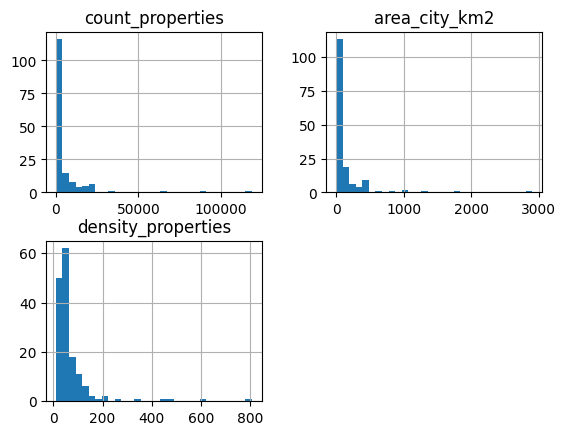

In [9]:
# hist plots
table_cities_count[['count_properties', 'area_city_km2', 'density_properties']].hist(bins=30)

In [10]:
# see top cities with more properties
table_cities_count.sort_values("count_properties", ascending=False).head(10)

,city_cluster,count_properties,area_city_km2,density_properties
0,0.0,118679,2903.853661,40.869484
12,12.0,87158,1790.617983,48.674816
21,21.0,67144,1262.912620,53.165990
9,9.0,34139,609.294647,56.030363
29,29.0,22551,271.880932,82.944397
48,48.0,22303,443.897147,50.243621
42,42.0,21622,968.555525,22.323965
16,16.0,21160,478.433650,44.227658
57,57.0,20894,426.496840,48.989812
2,2.0,20048,421.923013,47.515777


In [11]:
# see top cities with more density
(
    table_cities_count
    .sort_values("density_properties", ascending=False)
    .merge(
        gdf_cities.loc[:, ["city_cluster", "geometry"]],
        how="inner",
    )
    .pipe(gpd.GeoDataFrame)
    .explore(tiles="cartodbpositron")
    )

## Cut the cities

In [12]:
# get longitude & latitude of each property
gdf_properties["longitude"] = gdf_properties["geometry"].x
gdf_properties["latitude"] = gdf_properties["geometry"].y

### Example 1: CDMX

In [20]:
# use dbscan to cluster
CITY_CLUSTER_EXAMPLE = 12

# subset
gdf_properties_city = gdf_properties.query(f"city_cluster == {CITY_CLUSTER_EXAMPLE}").copy()

# 5 clusters
np.random.seed(42)  # for reproducibility in spectral clustering with amg
spectral_cluster = SpectralClustering(
    n_clusters=6, random_state=42, 
    eigen_solver='amg',
    # affinity='nearest_neighbors',
    # n_neighbors=1000,
    )

# fit predict
gdf_properties_city["subcluster_city"] = spectral_cluster.fit_predict(
    gdf_properties_city[["longitude", "latitude"]]
    )


In [19]:
# count properties in each cluster
gdf_properties_city["subcluster_city"].value_counts()

subcluster_city
0    109042
3      5072
2      3916
1       326
5       223
4       100
Name: count, dtype: int64

<Axes: >

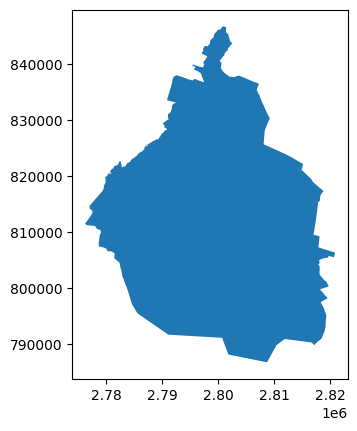

In [15]:
# get shape of cdmx and edomex
gdf_cdmx = geo_framework.Entidades(
    entidades=['09']
)

# change crs
gdf_cdmx = gdf_cdmx.to_crs("EPSG:6372")

# plot
gdf_cdmx.plot()

<Axes: >

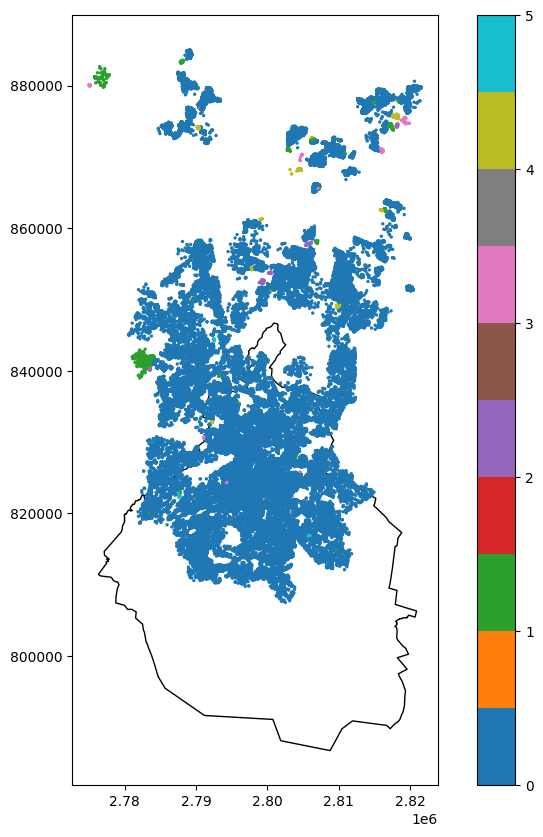

In [16]:
# plot
fig, ax = plt.subplots(figsize=(10, 10))
gdf_cdmx.plot(ax=ax, color='white', edgecolor='black')

(
    gdf_properties_city
    .pipe(gpd.GeoDataFrame)
    .plot(
        column="subcluster_city", legend=True, 
        figsize=(10, 10), ax=ax, cmap="tab10",
        markersize=2
        )
    )

### General Cuts

In [ ]:
# function to subclusterize depending on the city
def subclusterize_city(gdf_properties, city_cluster, n_clusters=6):
    # subset
    gdf_properties_city = gdf_properties.query(f"city_cluster == {city_cluster}").copy()

    # mini batch clusters
    mb_kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=0)

    # fit predict
    print("Fitting Clusters")
    gdf_properties_city["subcluster_city"] = mb_kmeans.fit_predict(
        gdf_properties_city[["longitude", "latitude"]]
        )

    # distribution of properties
    print(gdf_properties_city["subcluster_city"].value_counts())

    # plot
    print("Plotting")
    fig, ax = plt.subplots(figsize=(10, 10))

    (
        gdf_properties_city
        .pipe(gpd.GeoDataFrame)
        .plot(
            column="subcluster_city", legend=True, 
            figsize=(10, 10), ax=ax, cmap="tab10",
            markersize=2
            )
        )
    return


In [ ]:
# to cdmx
subclusterize_city(gdf_properties, city_cluster=0, n_clusters=6)

In [ ]:
# to cdmx
subclusterize_city(gdf_properties, city_cluster=12, n_clusters=5)

In [ ]:
# to cdmx
subclusterize_city(gdf_properties, city_cluster=21, n_clusters=3)

---
# Sandbox

In [ ]:
# search
gdf_cities.query("city_cluster == 21")

In [ ]:
gdf_cities